## 导包

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

In [2]:
import sklearn
sklearn.__version__

'0.19.1'

In [3]:
# s等下 别下载 就用这个啊pip install s
# lgb.version
# !pip install lightgbm

## 设置与读取

In [4]:
train_data = pd.read_csv('raw_data/train_public.csv')
submit_example = pd.read_csv('raw_data/submit_example.csv')
test_public = pd.read_csv('raw_data/test_public.csv')
train_inte = pd.read_csv('raw_data/train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

## 模型模块

In [5]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        clf = LGBMClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        clf.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_[feats], num_iteration=clf.best_iteration_)[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del clf, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [6]:

def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')

## 数据预处理

In [7]:
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])




## 对抗过拟合-特征粒度处理

## 时间特征

In [8]:
train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year






## Pcode 特征

## 精度处理，没有提升，不代表不对

## 精度处理后添加特征

## 自然编码

In [9]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum



## train 预测 Internet

In [10]:
y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)


Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[58]	training's auc: 0.933523	training's binary_logloss: 0.249533	valid_1's auc: 0.892153	valid_1's binary_logloss: 0.290676
Fold  1 AUC : 0.892153
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.954902	training's binary_logloss: 0.224771	valid_1's auc: 0.888907	valid_1's binary_logloss: 0.289767
Early stopping, best iteration is:
[64]	training's auc: 0.937329	training's binary_logloss: 0.246772	valid_1's auc: 0.891066	valid_1's binary_logloss: 0.28752
Fold  2 AUC : 0.891066
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[47]	training's auc: 0.93133	training's binary_logloss: 0.2514	valid_1's auc: 0.875276	valid_1's binary_logloss: 0.31178
Fold  3 AUC : 0.875276
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[54]	training's auc: 0.937112	training's binary_log

In [11]:
IntePre['isDef'] = train_inte['is_default']

D:\programfiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
# IntePre
# train_inteSame.head()

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)

0.7295666071674715

In [14]:
# inteSame
# InteId

In [15]:
# train_inteSame

In [16]:
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)




# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)


D:\programfiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if __name__ == '__main__':


D:\programfiles\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


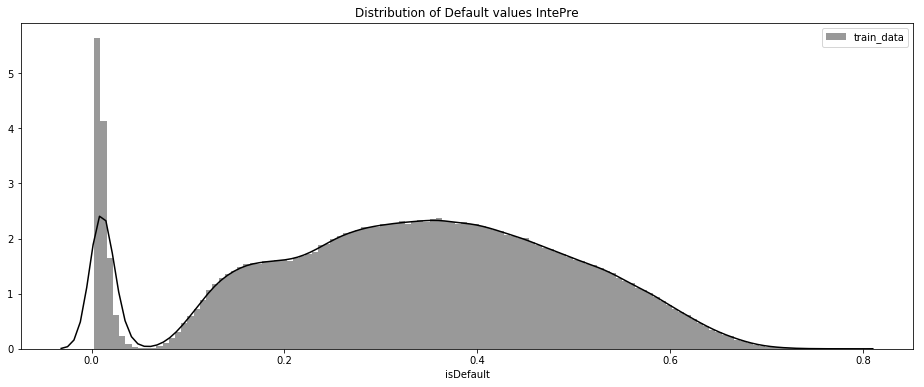

In [17]:
# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()

In [18]:
# len(train)

## 模型与输出

In [19]:
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)

Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.993455	training's binary_logloss: 0.0326974	valid_1's auc: 0.986005	valid_1's binary_logloss: 0.0452111
Early stopping, best iteration is:
[83]	training's auc: 0.992302	training's binary_logloss: 0.0343836	valid_1's auc: 0.98613	valid_1's binary_logloss: 0.0449613
Fold  1 AUC : 0.986130
Training until validation scores don't improve for 40 rounds
Early stopping, best iteration is:
[36]	training's auc: 0.989945	training's binary_logloss: 0.0396463	valid_1's auc: 0.984252	valid_1's binary_logloss: 0.044025
Fold  2 AUC : 0.984252
Training until validation scores don't improve for 40 rounds
[100]	training's auc: 0.992953	training's binary_logloss: 0.0340856	valid_1's auc: 0.985773	valid_1's binary_logloss: 0.042583
Early stopping, best iteration is:
[92]	training's auc: 0.992404	training's binary_logloss: 0.0348428	valid_1's auc: 0.98573	valid_1's binary_logloss: 0.042547
Fold  3 AUC : 0.985730
Training un

In [20]:
train.head()

,app_type,censor_status,class,dataSourse,debt_loan_ratio,del_in_18month,earliesCreditMon,earliesCreditYear,early_return,early_return_amount,early_return_amount_3mon,employer_type,f0,f1,f2,f3,f4,house_exist,industry,initial_list_status,interest,isDefault,issue_date_dayofweek,issue_date_month,known_dero,known_outstanding_loan,loan_id,monthly_payment,policy_code,post_code,pub_dero_bankrup,recircle_b,recircle_u,region,scoring_high,scoring_low,title,total_loan,use,user_id,work_year,year_of_loan
0,0.000,1,3,1,2.430,0.000,12,2001,3,9927,0.000,3,1.000,0.000,4.000,5.000,4.000,0,13,0,11.466,0.000,5,10,0.000,3.000,1040418,1174.910,1.000,193.000,0.000,7734.231,91.800,13,649.091,556.364,5.000,31818.182,2,240418,3,3
1,0.000,2,3,1,11.005,1.000,4,1990,0,0,0.000,3,7.000,0.000,4.000,45.000,22.000,0,13,1,16.841,0.000,5,6,0.000,3.000,1025197,670.690,1.000,491.000,0.000,31329.000,54.800,30,893.750,715.000,40642.000,28000.000,0,225197,10,5
2,0.000,0,1,1,6.409,0.000,10,1991,0,0,0.000,3,6.000,0.000,6.000,28.000,19.000,1,3,1,8.900,0.000,2,1,0.000,5.000,1009360,603.320,1.000,459.000,0.000,18514.000,57.692,8,903.636,774.545,154.000,17272.727,4,209360,10,3
3,0.000,1,1,1,9.205,0.000,6,2001,0,0,0.000,1,5.000,0.000,10.000,15.000,9.000,0,10,0,4.788,0.000,2,7,0.000,3.000,1039708,602.300,1.000,157.000,0.000,20707.000,42.600,8,875.000,750.000,0.000,20000.000,0,239708,6,3
4,0.000,1,3,1,15.578,0.000,5,2001,0,0,0.000,3,10.000,0.000,6.000,15.000,4.000,2,2,0,12.790,0.000,4,7,0.000,15.000,1027483,470.310,1.000,38.000,0.000,14016.154,30.462,21,710.606,609.091,0.000,15272.727,0,227483,0,3


In [21]:
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('submit/nn2.csv', index=False)

In [22]:
# train.issue_date_year.value_counts()

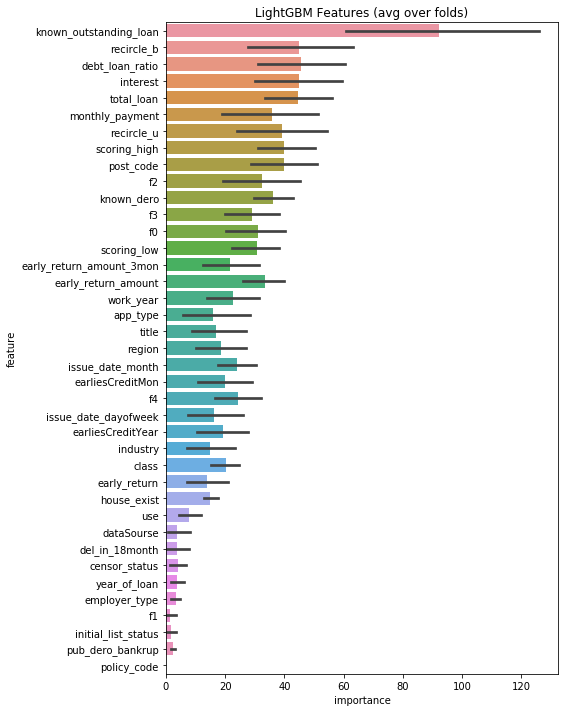

In [23]:
display_importances(importances)

# 处理一些取值精度后没有大的变化 依然是状态 / 得分
# 0.88142741347 

In [24]:
# train.nunique()